In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

При написании кода использовался Python 2.7

# Этап 1. Подготовка данных и первичный анализ

Для начала загружу данные обучающей выборки и разделю ее на три части, для последующего обучения и тестирования

In [23]:
facts = pd.read_csv("01_Facts_csv.csv", sep = ";", header=None)

In [24]:
train_1 = facts[:][0:40]
train_2 = facts[:][40:81]
train_3 = facts[:][81:122]

Функция ниже преобразует данные в два стобца, где в первом столбце стоят номера, а во втором идентификаторы людей, которым они принадлежат

In [25]:
def prepare(data):
    s1 = pd.Series(data[0])
    s2 = pd.Series(data[1])
    Numbers = pd.Series(list(pd.concat([s1, s2], axis = 0)))
    ind = pd.Series(range(len(s1)))
    id_= pd.Series(list(pd.concat([ind, ind])))
    T = pd.concat([Numbers, id_], axis = 1)
    return T

In [26]:
train_1 = prepare(train_1)
train_2 = prepare(train_2)
train_3 = prepare(train_3)

Пример:

In [150]:
train_1.head(10)

,0,1
0,158530067653,0
1,158510912201,1
2,158530063945,2
3,158524011325,3
4,158528852153,4
5,158510912383,5
6,158503851673,6
7,158524011011,7
8,158524011043,8
9,158524002695,9


Теперь загрузим данные о маршрутах этих номеров

In [159]:
df = pd.read_csv('02_Data_test_test.csv',sep = ';')
df = df.drop(['Unnamed: 12','Unnamed: 13','Unnamed: 14'], axis = 1)

Визуализирую данные

In [160]:
import folium
from folium.plugins import MarkerCluster
%matplotlib inline

Возьму пример двух номеров принадлежащих одному человеку (взял из файла facts)

In [161]:
number_1 = df[ df['msisdn'] == 158510090027] # 15й номер в файле 01-Facts.xlsx
number_2 = df[ df['msisdn'] == 158528850875]

In [162]:
number_1.head(5) # Все даные только по одному номеру

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle
9426,7706,6289,158510090027,013428002245160,0,1369282694428,37.5082,55.6958,1224,OUTDOOR,191.5,238.5
10283,7706,6289,158510090027,013428002245160,3,1369284066093,37.5082,55.6958,1224,OUTDOOR,191.5,238.5
10284,7752,57570,158510090027,null,0,1369284066103,37.4995,55.7062,618,OUTDOOR,105.0,165.0
10513,7752,57569,158510090027,013428002245160,8,1369284413635,37.4995,55.7062,873,OUTDOOR,0.0,60.0
10789,7752,57569,158510090027,013428002245160,3,1369284789947,37.4995,55.7062,873,OUTDOOR,0.0,60.0


In [163]:
number_1_points = (number_1[['lat', 'long']])
number_2_points = (number_2[['lat', 'long']])

In [164]:
center = [55.7062, 37.4995]
Map_1 = folium.Map(location = center, zoom_start=11, control_scale=True)

In [165]:
Places_cluster = MarkerCluster(locations=number_1_points.values)
Places_cluster.add_to(Map_1)
Map_1

Посмотрим на распределение точек по Москве для первого и второго номера

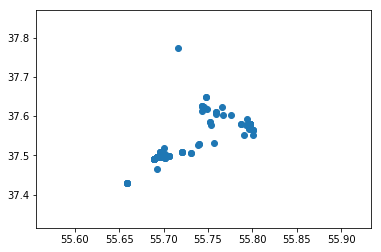

In [172]:
plt.axis([55.556834, 55.933873, 37.315441, 37.869122])
plt.scatter(np.array(number_1_points)[:,0], np.array(number_1_points)[:, 1]) # маршрут номера 158510090027

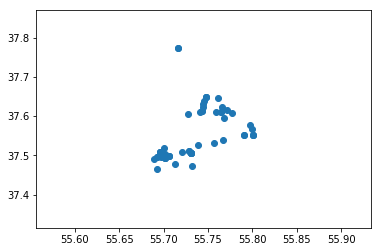

In [171]:
plt.axis([55.556834, 55.933873, 37.315441, 37.869122])
plt.scatter(np.array(number_2_points)[:,0], np.array(number_2_points)[:, 1]) # маршрут номера 158528850875

Как видно из картинок маршруты похожи в большинстве точек, тогда будем сравнивать похожесть номеров на основе числа точек (соответствующих вышкам) в которых они совпадают.

В этом нам поможет метод CountVectorization, используемый для преобразования текста в вектор при поиске дубликатов, но в нашем случае задача очень похожа

Функция ниже делает вектора для последующего применения в CountVectorizer. Более подробно, она записывает в виде текста последовательность идентификаторов вышек в которых был номер попутно выкидывая номера, которые были в df, чтобы они не попали в Validate

In [28]:
def make_train_data(train, df):
    train_data = []

    for i in range(len(train[0])):
        det = df[ df['msisdn'] == train[0][i]]
        df = df.drop (list(det.index), axis = 0)  # выкинули номера из train

        if det.shape[0] == 0:
            train = train.drop(i, axis = 0)
            continue
        
        row_1 = []
        for i in range(det.shape[0]):
            row_1.append(str(int(pd.DataFrame(det['lac']).iloc[i])) + str(int(pd.DataFrame(det['cid']).iloc[i])))
        str1 = row_1[0]
        for i in range(1, len(row_1)):
            str1 = str1 + ' ' + row_1[i]
        
        train_data.append(str1)
    return train_data, train, df

In [29]:
train_data_1, train_1, df = make_train_data(train_1, df)
train_data_2, train_2, df = make_train_data(train_2, df)
train_data_3, train_3, df = make_train_data(train_3, df)

In [154]:
train_1[0][0]

158530067653

Пример

In [152]:
train_data_1[0] # последовательность идентификаторов вышек в которых был номер 158530067653
                # идентификатор вышки, это ее Lac и CID записанные последовательно

'778248428 775230479 774258364 774226211 779920136 77999705 77999705 77997173 77999705 779921582 778262614 77823893 778230191 778230316 778230316 778236699 778265450 778258147 778236072 775230479 77526851 775231486 774254601 774363134 774259881 774358795 77999705 77999705 77999705 77999705 77999705 779929294 77992799 774229964 774259881 77429596 774238557 77429596 774230720 774235425 774235420 77429803 774230720 778265450 77824354 77829763 77824353 77824353 501960210 509128514 507450941 50748724 507451563 50748724 507451563 507452473 50748724 507465174 507465174 50748724'

Проделаю тоже самое с выборкой Validate

In [34]:
validate_data = []

for x in df['msisdn'].unique():
    det = df[ df['msisdn'] == x ]
    
    if det.shape[0] == 0:
        continue
    
    row_1 = []
    for i in range(det.shape[0]):
        row_1.append(str(int(pd.DataFrame(det['lac']).iloc[i])) + str(int(pd.DataFrame(det['cid']).iloc[i])))
    str1 = row_1[0]
    for i in range(1, len(row_1)):
        str1 = str1 + ' ' + row_1[i]
        
    validate_data.append(str1)

Объединим все данные в одну базу, чтобы применить CountVectorizer ко всем данным, чтобы каждый вектор имел сведения обо всех уникальных базовых станциях 

In [89]:
Data = train_data_1
Data.extend(train_data_2)
Data.extend(train_data_3)
Data.extend(validate_data)

# Этап 2. Готовим модель

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

Применим методCountVectorizer для получения векторов

In [90]:
count_vect = CountVectorizer()

In [91]:
X_new_counts = count_vect.fit_transform(Data)
X = X_new_counts.toarray()

Вновь разделим данные для  применения алгоритма

In [92]:
train_1_X = X[0:77]
train_2_X = X[77:159]
train_3_X = X[159:241]
validate_X = X[241:2361]

Для выявления дубликатов (номеров принадлежащих одному человеку) будем использовать Аггломеративный алгоритм, это алгоритм кластеризации суть которого заключается в том, что он сначала представляет все вектора в виде кластеров, а потом последовательно объединяет самые близкие пары точек в один кластер.

Таким образом, наша задача заключается в том, чтобы подобрать расстояние на котором он объединит большинство пар точек, а точки не являющиеся дубликатами (а такие по условию тоже есть) он просто оставит на месте.

Для оценки качества полученной модели воспользуемся метрикой качества - Adjusted Rand Score

In [46]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
import sklearn.metrics as smt

В качестве расстояния будем использовать корреляцию, так как она показала себя лучше всего из всех остальных метрик

In [110]:
distance_mat = pdist(train_1_X, metric = 'correlation')

In [111]:
Res = hierarchy.linkage(distance_mat, 'single')

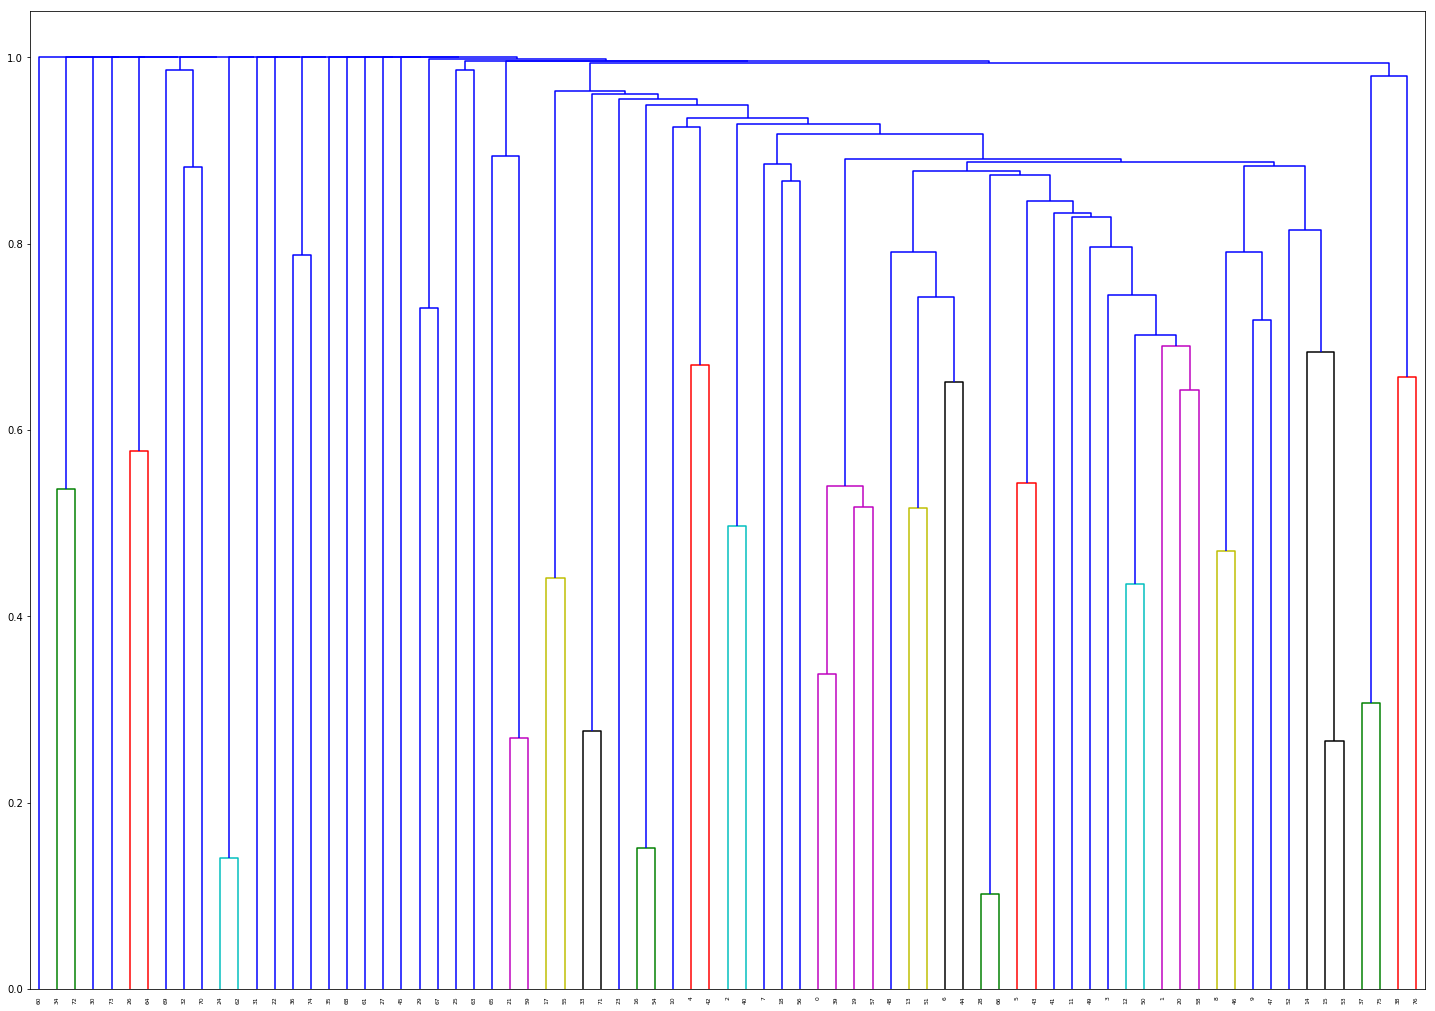

In [112]:
plt.figure(figsize=(25,18))
dn = hierarchy.dendrogram(Res)

На оси Абсцисс располагаются точки, а на оси Ординат расстояние на котором они объединяются в один кластер

Для оптимального подбора расстояния, на котором стоит разрезать дендограмму построим график зависимости ARI от этого расстояния 

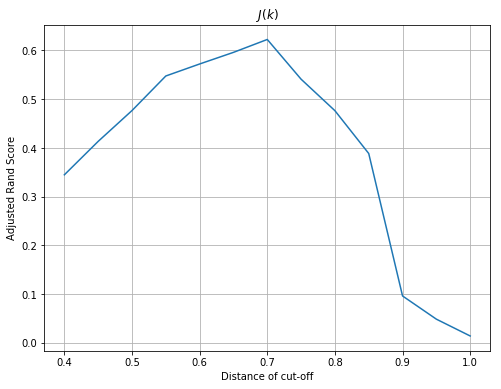

In [120]:
y = list(train_1[1])
ks = [0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
criteria = np.zeros(len(ks))

for i in range(len(ks)):
    clusters = fcluster(Res, ks[i] , criterion='distance')
    criteria[i] = smt.adjusted_rand_score(y, clusters)
    
    
plt.figure(figsize=(8, 6))
plt.plot(ks, criteria)
plt.ylabel("Adjusted Rand Score")
plt.xlabel("Distance of cut-off")
plt.grid()
plt.show()

In [121]:
clusters = fcluster(Res, 0.7, criterion='distance')
print "Adjusted Rand index is: %.2f" % smt.adjusted_rand_score(y, clusters)

Adjusted Rand index is: 0.62


Для проверки корректности, проведем аналогичные действия с двумя другими частями Обучающей выборки

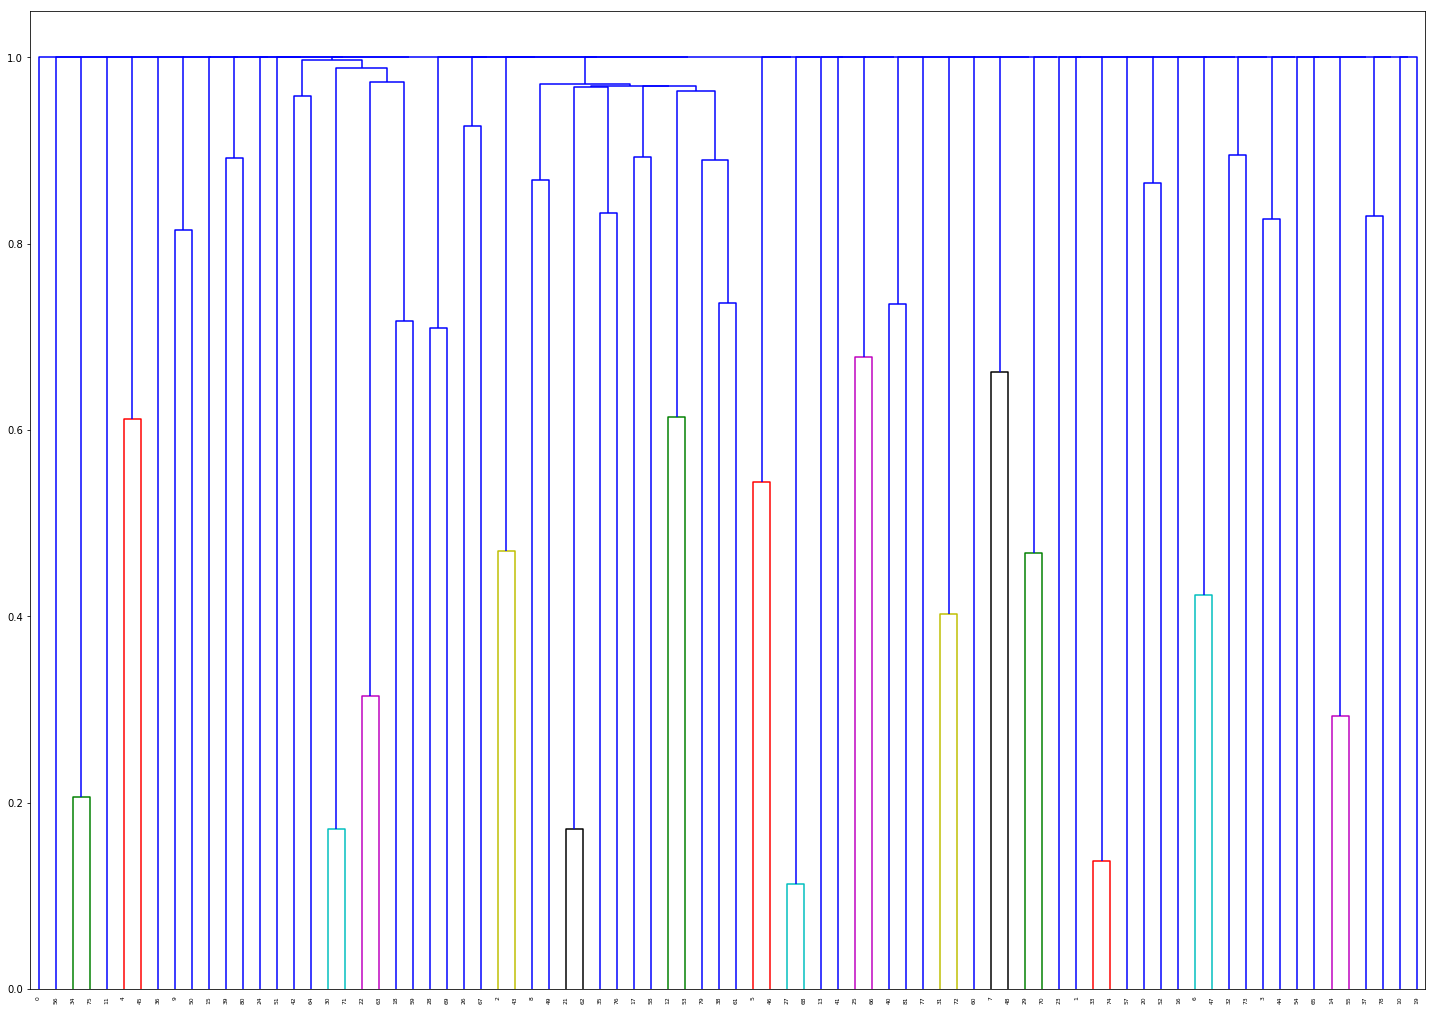

In [122]:
distance_mat = pdist(train_2_X, metric = 'correlation')
Res = hierarchy.linkage(distance_mat, 'single')
plt.figure(figsize=(25,18))
dn = hierarchy.dendrogram(Res)

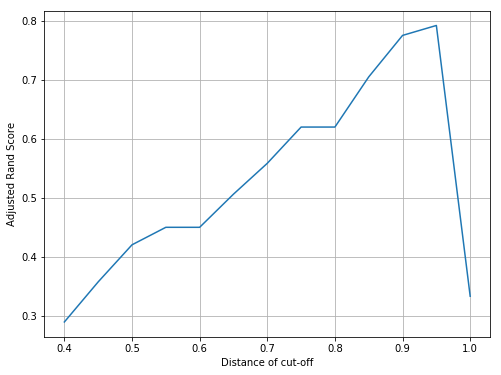

In [125]:
y = list(train_2[1])
ks = [0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
criteria = np.zeros(len(ks))

for i in range(len(ks)):
    clusters = fcluster(Res, ks[i] , criterion='distance')
    criteria[i] = smt.adjusted_rand_score(y, clusters)
    
    
plt.figure(figsize=(8, 6))
plt.plot(ks, criteria)
plt.ylabel("Adjusted Rand Score")
plt.xlabel("Distance of cut-off")
plt.grid()
plt.show()

In [124]:
y = list(train_2[1])
clusters = fcluster(Res, 0.95, criterion='distance')
print "Adjusted Rand index is: %.2f" % smt.adjusted_rand_score(y, clusters)

Adjusted Rand index is: 0.79


Результат даже лучше 

Теперь запустим на третьей выборке

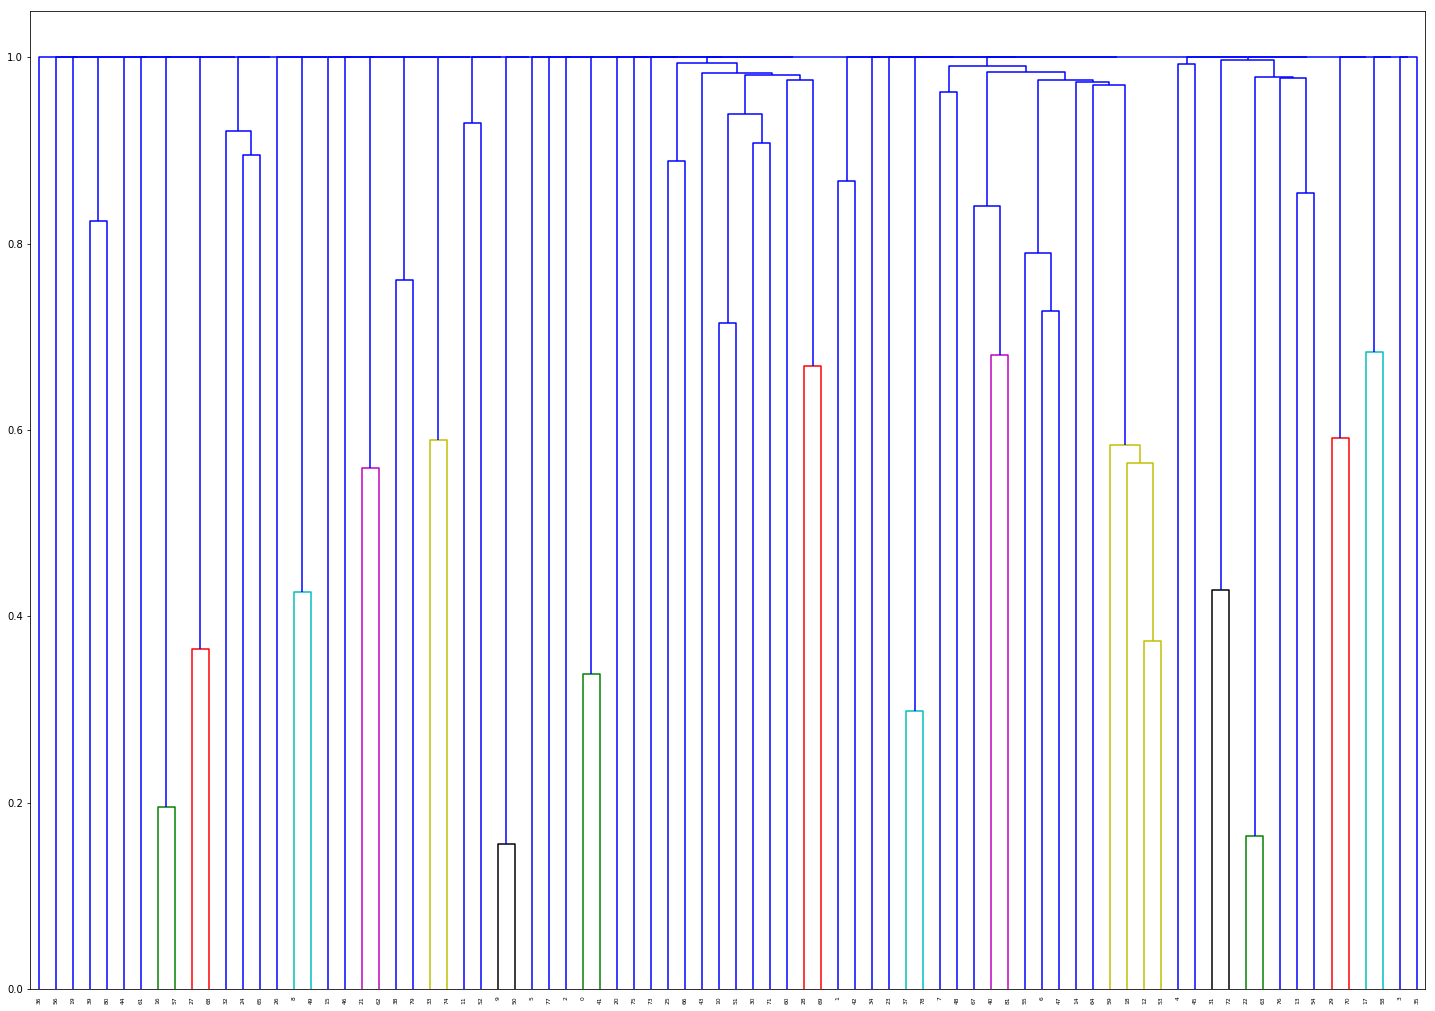

In [126]:
distance_mat = pdist(train_3_X, metric = 'correlation')
Res = hierarchy.linkage(distance_mat, 'single')
plt.figure(figsize=(25,18))
dn = hierarchy.dendrogram(Res)

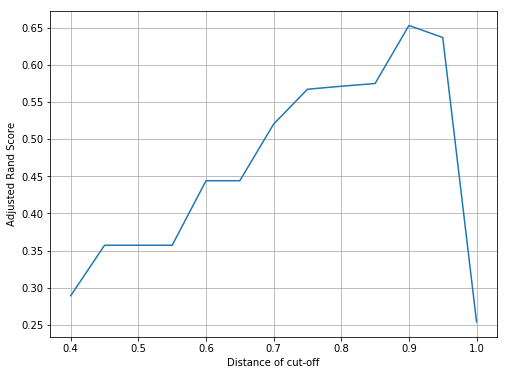

In [127]:
y = list(train_3[1])
ks = [0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
criteria = np.zeros(len(ks))

for i in range(len(ks)):
    clusters = fcluster(Res, ks[i] , criterion='distance')
    criteria[i] = smt.adjusted_rand_score(y, clusters)
    
    
plt.figure(figsize=(8, 6))
plt.plot(ks, criteria)
plt.ylabel("Adjusted Rand Score")
plt.xlabel("Distance of cut-off")
plt.grid()
plt.show()

In [128]:
y = list(train_3[1])
clusters = fcluster(Res, 0.9, criterion='distance')
print "Adjusted Rand index is: %.2f" % smt.adjusted_rand_score(y, clusters)

Adjusted Rand index is: 0.65


Теперь мы готовы применять алгоритм на Validate части

# Этап 3. Применим на Validate

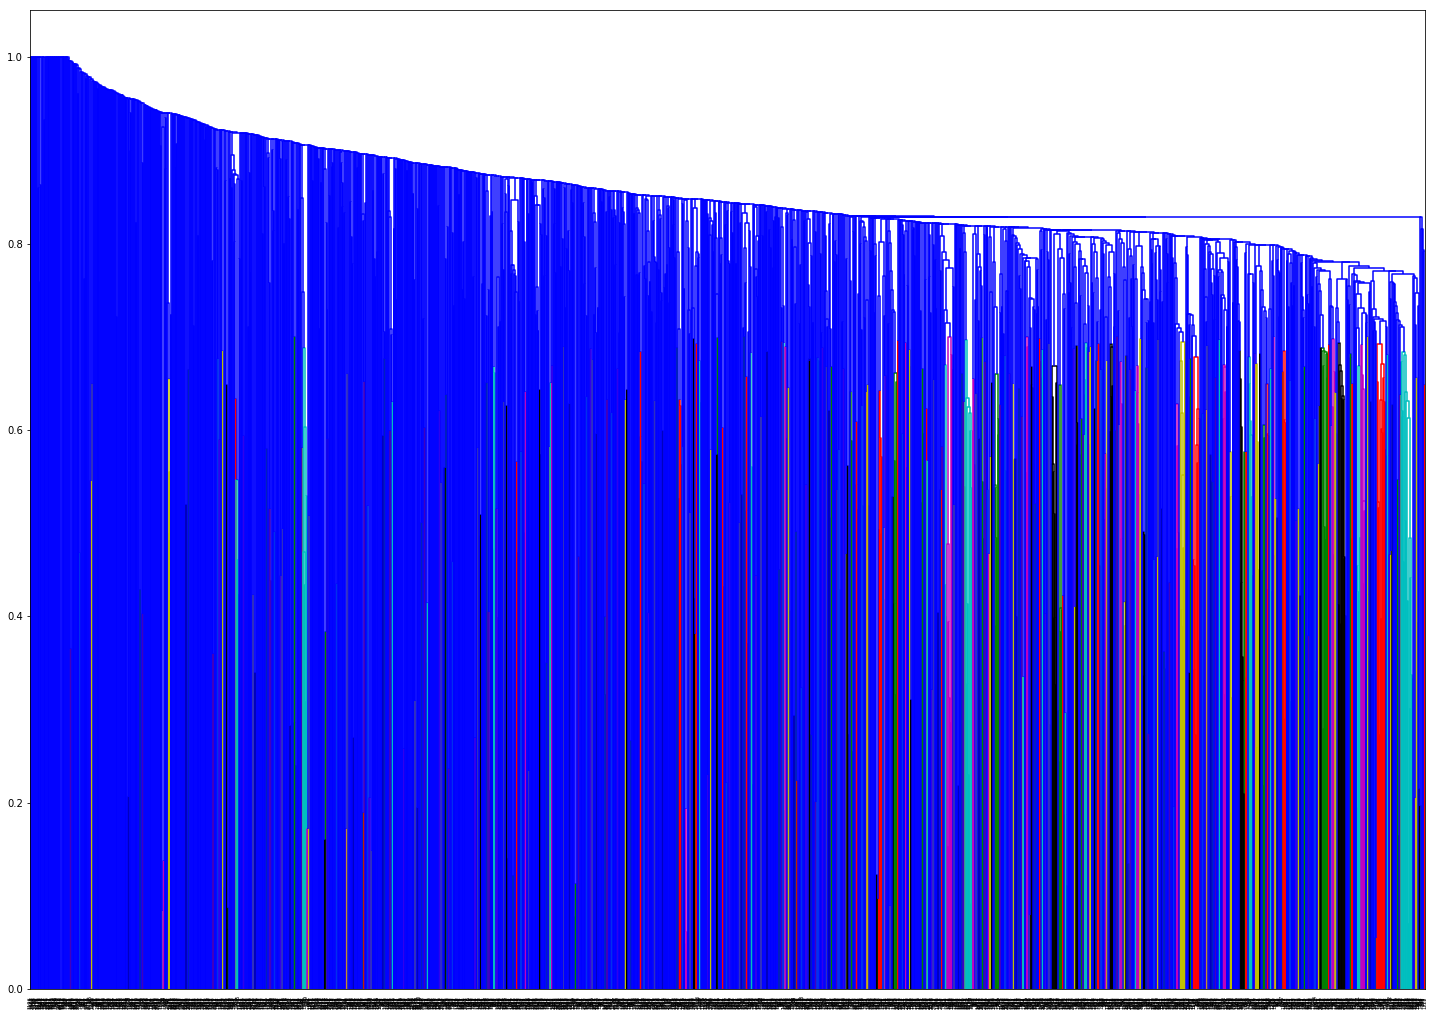

In [102]:
distance_mat = pdist(validate_X, metric = 'correlation')
Res = hierarchy.linkage(distance_mat, 'single')
plt.figure(figsize=(25,18))
dn = hierarchy.dendrogram(Res)

In [104]:
clusters = fcluster(Res, 0.6, criterion='distance')

# Сохраним результат

In [106]:
numbers = df['msisdn'].unique()

In [107]:
s1 = pd.Series(numbers)
s2 = pd.Series(clusters)
result = pd.concat([s1, s2], axis = 1, keys=['number','id'])
result.head(7)

,number,id
0,158529599791,1446
1,158520145943,1128
2,158521798391,1165
3,158537830573,466
4,158510204039,1079
5,158528782737,19
6,158534117157,83


In [108]:
grouped = result.groupby('id')

Result = []
for name,group in grouped:
    raw = []
    raw.append(name)
    raw.extend([x for x in group['number']])
    Result.append(raw)

Тогда результат выглядит следующим образом

In [109]:
Result

[[1, 158536338179],
 [2, 158523211793],
 [3, 158500159523],
 [4, 158500019021],
 [5, 158525414061],
 [6, 158531154569],
 [7, 158533994253],
 [8, 158500832775, 158533886039],
 [9, 158516092627],
 [10, 158538122633],
 [11, 158523058067, 158502009901],
 [12, 158522270977],
 [13, 158522029013],
 [14, 158537657865, 158530000013],
 [15, 158507575155],
 [16, 158516040635],
 [17, 158530000899],
 [18, 158504466713],
 [19, 158528782737, 158598151595],
 [20, 158514731597],
 [21, 158530470765],
 [22, 158517117705],
 [23, 158539863973],
 [24, 158525689937],
 [25, 158533553405],
 [26, 158530868885, 158517454219],
 [27, 158507512341],
 [28, 158531723599],
 [29, 158530079915],
 [30, 158527406681],
 [31, 158533952529],
 [32, 158503531357],
 [33, 158517798705, 158520467311],
 [34, 158525274517, 158502501165],
 [35, 158528113249],
 [36, 158514801451],
 [37, 158526471471],
 [38, 158526845901, 158521175471],
 [39, 158538257071, 158538483063],
 [40, 158535066167],
 [41, 158524221759],
 [42, 158503506547],
 

Запишем их в CSV

In [178]:
import csv
import io

In [179]:
FILENAME = "Result.csv"

with open(FILENAME, "w") as file:
    writer = csv.writer(file)
    writer.writerows(Result)